<a href="https://colab.research.google.com/github/raisa2010/content-moderation-cookbook/blob/main/ContentModeration_Experiment1_FineTunedClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

from importlib.metadata import version

import torch

from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    logging,
    pipeline,
)
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import pytz
import seaborn as sns
import torch
import warnings

In [ ]:
from google.colab import userdata
api_key = userdata.get('KAGGLE_API_KEY')

!pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!rm -rf /content/*
!kaggle datasets download "denizbilginn/google-maps-restaurant-reviews"
!unzip google-maps-restaurant-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews
License(s): ODbL-1.0
 99% 653M/657M [00:00<00:00, 1.32GB/s]
100% 657M/657M [00:00<00:00, 1.33GB/s]
Archive:  google-maps-restaurant-reviews.zip
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_enes_ozturk.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_erdal_dalgalar.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_nezahat_arslan.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_nihat_karabiber.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_ersin_kocabaldir.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_omer_ata.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_suat_ozdogan.png  
  inflating: dataset/dataset/indoor_atmosphere/akpinar_restaurant_selim_cukur.png  
  inflating: dataset/dataset/indoor_atmosphere/akpinar_restaurant_sibel_sarayli.png  
  inflating: dataset/dat

In [ ]:
import pandas as pd

basepath = "google-maps-restaurant-reviews"
rca_df = pd.read_csv("reviews.csv")
rca_df.head()

,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


EDA:
- Drop any nil values from any column
- Plot total number of reviewers and categories
- Plot the average rating per restaurant, per reviewer, per category
- Plot the min, max, average length of a review
- Plot most frequently used words in the review barring stop words

rating_category
indoor_atmosphere     288
menu                  196
outdoor_atmosphere    286
taste                 330
dtype: int64


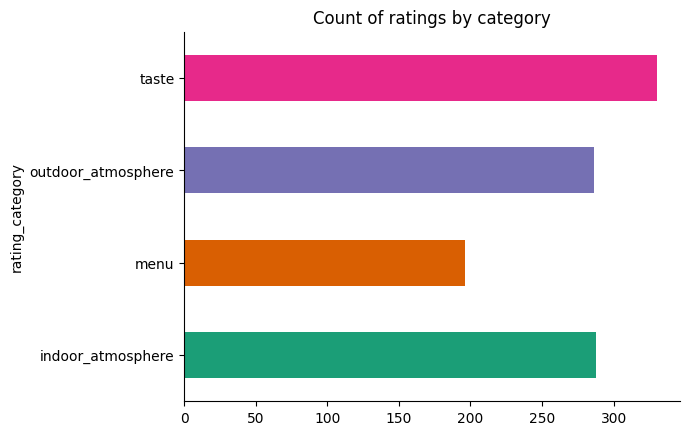

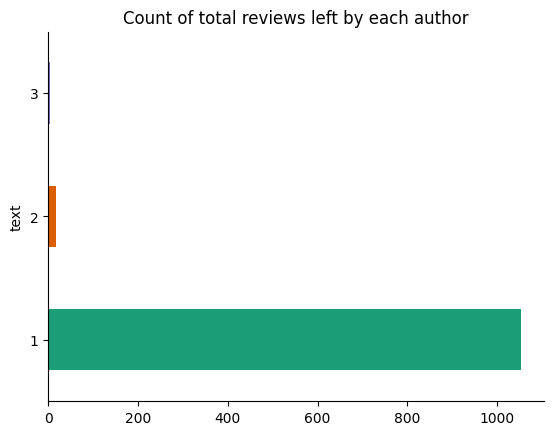

                    text
business_name           
Abidin Tantuni        11
Ahsap Iskender        11
Akpinar Restaurant    11
Alavara               11
Alsancak Firin        11


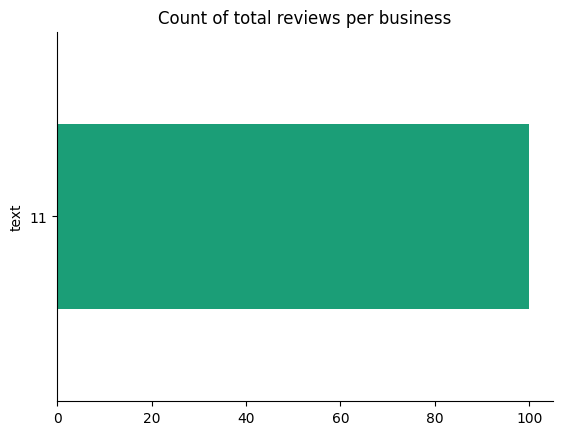

In [ ]:
# Drop rows where there are any nil values
rca_df.dropna()
print(rca_df.groupby('rating_category').size())

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

rca_df.groupby('rating_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Count of ratings by category')
plt.show()

# Distribution of reviews per author
review_count_df = rca_df.groupby('author_name').agg({'text': 'count'}).apply(lambda x: x.sort_values(ascending=False))

# TODO: more accurate labels for x and y axis, spacing between diagrams
review_count_df.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Count of total reviews left by each author')
plt.show()

# Distribution of reviews per business -> exactly 11 reviews per business
review_count_per_business_df = rca_df.groupby('business_name').agg({'text': 'count'}).apply(lambda x: x.sort_values(ascending=False))
print(review_count_per_business_df.head())
review_count_per_business_df.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Count of total reviews per business')
plt.show()

In [ ]:
!pip install transformers
!pip install datasets
!pip install tokenizers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
# Install required packages
!pip install transformers datasets pandas matplotlib seaborn tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    BertTokenizer,
    RobertaTokenizer,
    DistilBertTokenizer,
    GPT2Tokenizer,
    T5Tokenizer,
    XLNetTokenizer,
    AlbertTokenizer
)
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Define tokenizers to test
tokenizer_configs = {
    'BERT Base': 'bert-base-uncased',
    'BERT Large': 'bert-large-uncased',
    'RoBERTa Base': 'roberta-base',
    'RoBERTa Large': 'roberta-large',
    'DistilBERT': 'distilbert-base-uncased',
    'DistilBERTFineTuned': 'distilbert-base-uncased-finetuned-sst-2-english',
    'GPT-2': 'gpt2',
    'GPT-2 Medium': 'gpt2-medium',
    'T5 Small': 't5-small',
    'T5 Base': 't5-base',
    'XLNet Base': 'xlnet-base-cased',
    'ALBERT Base': 'albert-base-v2',
    'ALBERT Large': 'albert-large-v2'
}

# Initialize tokenizers
print("Loading tokenizers...")
tokenizers = {}
failed_tokenizers = []

for name, model_name in tokenizer_configs.items():
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        tokenizers[name] = tokenizer
        print(f"✓ Loaded {name}")
    except Exception as e:
        print(f"✗ Failed to load {name}: {str(e)}")
        failed_tokenizers.append(name)

print(f"\nSuccessfully loaded {len(tokenizers)} tokenizers")
print(f"Failed to load: {failed_tokenizers}")

Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Loaded BERT Base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Loaded BERT Large


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded RoBERTa Base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded RoBERTa Large


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Loaded DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

✓ Loaded DistilBERTFineTuned


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded GPT-2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded GPT-2 Medium


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

✓ Loaded T5 Small


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

✓ Loaded T5 Base


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

✓ Loaded XLNet Base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

✓ Loaded ALBERT Base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

✓ Loaded ALBERT Large

Successfully loaded 13 tokenizers
Failed to load: []


Starting comprehensive tokenizer analysis...

Analyzing BERT Base...

Analyzing BERT Large...

Analyzing RoBERTa Base...

Analyzing RoBERTa Large...

Analyzing DistilBERT...

Analyzing DistilBERTFineTuned...

Analyzing GPT-2...

Analyzing GPT-2 Medium...

Analyzing T5 Small...

Analyzing T5 Base...

Analyzing XLNet Base...

Analyzing ALBERT Base...

Analyzing ALBERT Large...

TOKENIZER PERFORMANCE COMPARISON

Performance Metrics:
          tokenizer  avg_tokens_per_text  std_tokens_per_text  tokenization_time  tokens_per_second  vocab_size
          BERT Base               27.909               16.212              0.345          88883.106       30522
         BERT Large               27.909               16.212              0.351          87381.393       30522
       RoBERTa Base               27.485               15.760              0.314          96390.255       50265
      RoBERTa Large               27.485               15.760              0.315          96112.559       50265
      

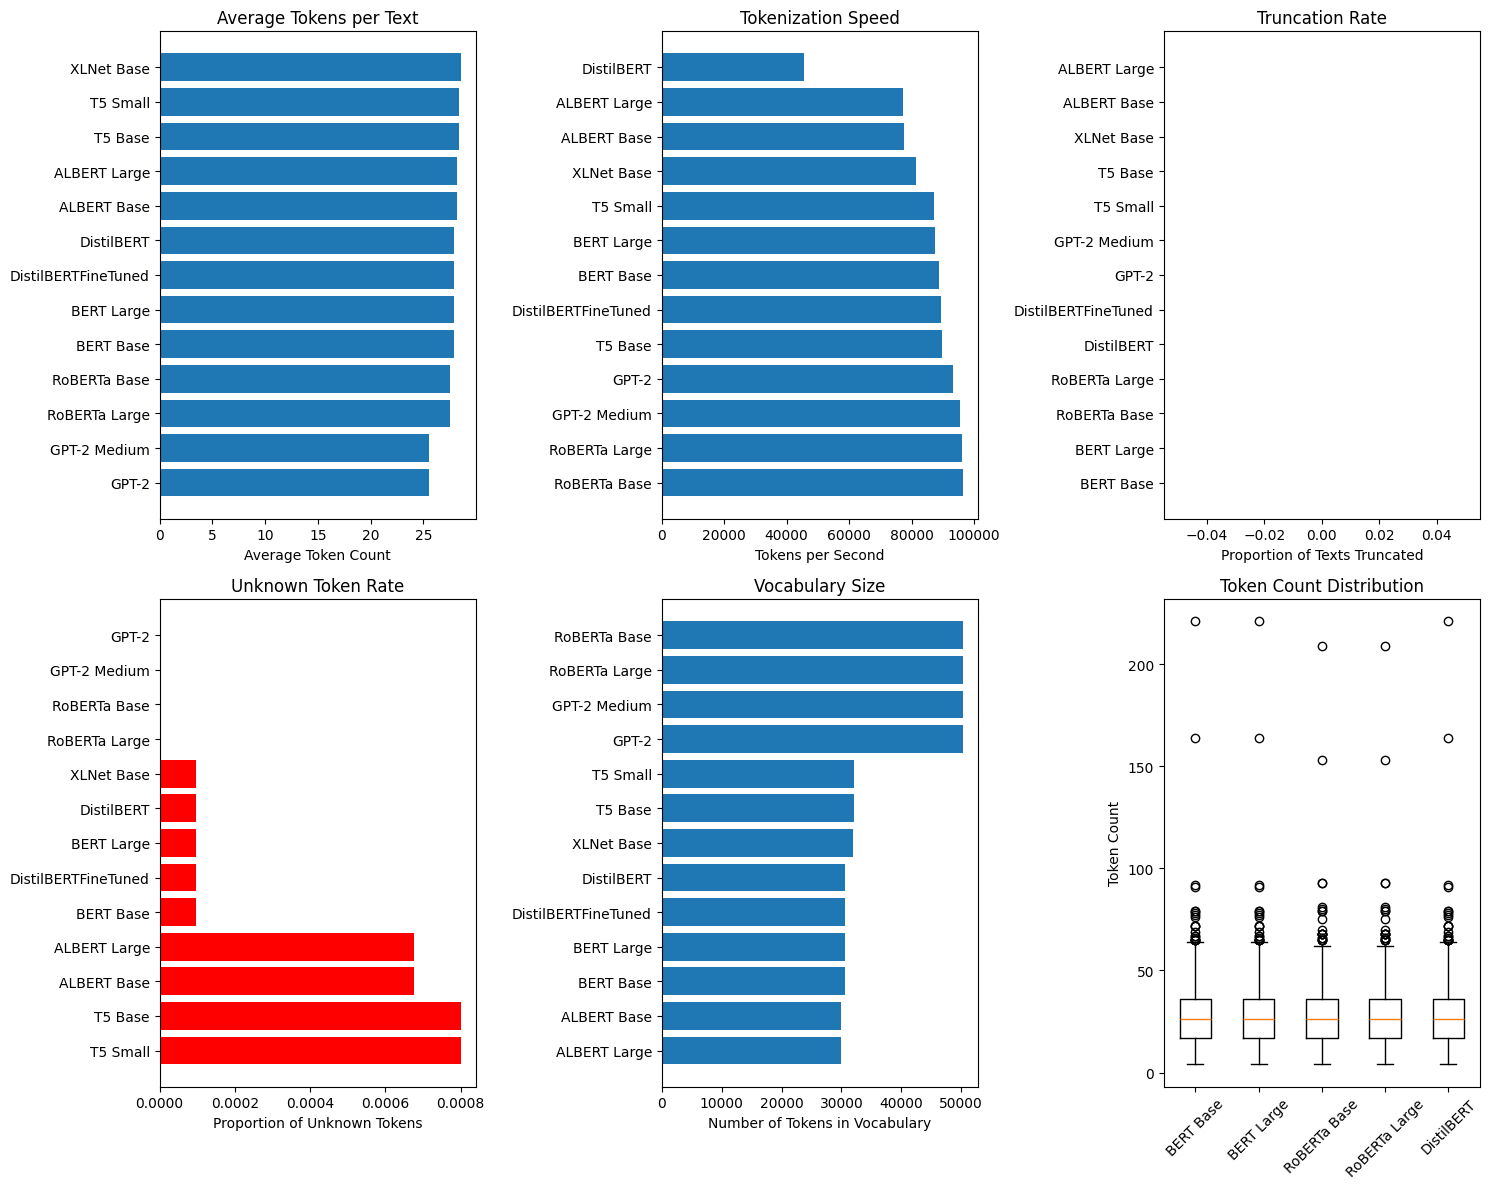


RECOMMENDATIONS
🚀 Fastest tokenizer: RoBERTa Base (96390.3 tokens/sec)
✂️  Least truncation: BERT Base (0.0% truncation rate)
❓ Fewest unknown tokens: RoBERTa Base (0.000% unknown rate)
📊 Most consistent: RoBERTa Base (std dev: 15.76)

📁 Results exported to 'tokenizer_comparison_results.csv'

ANALYSIS COMPLETE


In [ ]:
def analyze_tokenizer_performance(tokenizers, texts, max_length=512):
    """
    Comprehensive analysis of tokenizer performance
    """
    results = []

    for tokenizer_name, tokenizer in tokenizers.items():
        print(f"\nAnalyzing {tokenizer_name}...")

        # Performance metrics
        start_time_iterative = time.time()

        # Tokenization results for all texts
        tokenized_results = []
        truncated_count = 0
        total_tokens = 0
        unknown_tokens_count = 0
        token_lengths = []

        for text in texts:
            # Tokenize with attention to truncation
            encoded = tokenizer(
                text,
                truncation=True,
                max_length=max_length,
                return_tensors=None,
                add_special_tokens=True
            )

            # Get tokens
            tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])
            token_lengths.append(len(tokens))
            total_tokens += len(tokens)

            # Check for truncation by comparing original encoding vs non-truncated
            non_truncated = tokenizer(text, truncation=False, add_special_tokens=True)
            if len(encoded['input_ids']) < len(non_truncated['input_ids']):
                truncated_count += 1

            # Count unknown tokens
            unk_token = tokenizer.unk_token if hasattr(tokenizer, 'unk_token') else '[UNK]'
            if unk_token:
                unknown_tokens_count += tokens.count(unk_token)

            tokenized_results.append({
                'text': text[:50] + '...' if len(text) > 50 else text,
                'token_count': len(tokens),
                'tokens': tokens[:10],  # First 10 tokens for inspection
                'truncated': len(encoded['input_ids']) < len(non_truncated['input_ids'])
            })

        tokenization_time = time.time() - start_time_iterative

        # Calculate statistics
        avg_tokens_per_text = np.mean(token_lengths)
        std_tokens_per_text = np.std(token_lengths)
        vocab_size = len(tokenizer.vocab) if hasattr(tokenizer, 'vocab') else tokenizer.vocab_size

        results.append({
            'tokenizer': tokenizer_name,
            'avg_tokens_per_text': avg_tokens_per_text,
            'std_tokens_per_text': std_tokens_per_text,
            'total_tokens': total_tokens,
            'truncated_texts': truncated_count,
            'truncation_rate': truncated_count / len(texts),
            'unknown_tokens': unknown_tokens_count,
            'unknown_token_rate': unknown_tokens_count / total_tokens if total_tokens > 0 else 0,
            'tokenization_time': tokenization_time,
            'tokens_per_second': total_tokens / tokenization_time if tokenization_time > 0 else 0,
            'vocab_size': vocab_size,
            'tokenized_examples': tokenized_results
        })

    return results

# Run the analysis
print("Starting comprehensive tokenizer analysis...")
analysis_results = analyze_tokenizer_performance(tokenizers, rca_df['text'].tolist())

# Create results DataFrame
results_df = pd.DataFrame(analysis_results)

# Display comprehensive results
print("\n" + "="*80)
print("TOKENIZER PERFORMANCE COMPARISON")
print("="*80)

# Performance metrics table
performance_columns = ['tokenizer', 'avg_tokens_per_text', 'std_tokens_per_text',
                      'tokenization_time', 'tokens_per_second', 'vocab_size']
print("\nPerformance Metrics:")
print(results_df[performance_columns].round(3).to_string(index=False))

print("\n" + "-"*80)
print("TRUNCATION ANALYSIS")
print("-"*80)

truncation_columns = ['tokenizer', 'truncated_texts', 'truncation_rate']
truncation_df = results_df[truncation_columns].sort_values('truncation_rate', ascending=False)
print(truncation_df.round(3).to_string(index=False))

print("\n" + "-"*80)
print("UNKNOWN TOKENS ANALYSIS")
print("-"*80)

unknown_columns = ['tokenizer', 'unknown_tokens', 'unknown_token_rate']
unknown_df = results_df[unknown_columns].sort_values('unknown_token_rate', ascending=False)
print(unknown_df.round(4).to_string(index=False))

# Detailed tokenization examples
print("\n" + "-"*80)
print("TOKENIZATION EXAMPLES (First 3 texts)")
print("-"*80)

for result in analysis_results[:3]:  # Show first 3 tokenizers
    print(f"\n{result['tokenizer']}:")
    for i, example in enumerate(result['tokenized_examples'][:3]):  # First 3 texts
        truncated_indicator = " [TRUNCATED]" if example['truncated'] else ""
        print(f"  Text {i+1}: {example['text']}")
        print(f"    Tokens ({example['token_count']}): {example['tokens'][:10]}...{truncated_indicator}")

# Create visualizations
plt.figure(figsize=(15, 12))

# 1. Average tokens per text
plt.subplot(2, 3, 1)
sorted_results = results_df.sort_values('avg_tokens_per_text')
plt.barh(sorted_results['tokenizer'], sorted_results['avg_tokens_per_text'])
plt.title('Average Tokens per Text')
plt.xlabel('Average Token Count')
plt.tight_layout()

# 2. Tokenization speed
plt.subplot(2, 3, 2)
sorted_results = results_df.sort_values('tokens_per_second', ascending=False)
plt.barh(sorted_results['tokenizer'], sorted_results['tokens_per_second'])
plt.title('Tokenization Speed')
plt.xlabel('Tokens per Second')

# 3. Truncation rate
plt.subplot(2, 3, 3)
sorted_results = results_df.sort_values('truncation_rate', ascending=False)
colors = ['red' if rate > 0 else 'green' for rate in sorted_results['truncation_rate']]
plt.barh(sorted_results['tokenizer'], sorted_results['truncation_rate'], color=colors)
plt.title('Truncation Rate')
plt.xlabel('Proportion of Texts Truncated')

# 4. Unknown token rate
plt.subplot(2, 3, 4)
sorted_results = results_df.sort_values('unknown_token_rate', ascending=False)
colors = ['red' if rate > 0 else 'green' for rate in sorted_results['unknown_token_rate']]
plt.barh(sorted_results['tokenizer'], sorted_results['unknown_token_rate'], color=colors)
plt.title('Unknown Token Rate')
plt.xlabel('Proportion of Unknown Tokens')

# 5. Vocabulary size
plt.subplot(2, 3, 5)
sorted_results = results_df.sort_values('vocab_size')
plt.barh(sorted_results['tokenizer'], sorted_results['vocab_size'])
plt.title('Vocabulary Size')
plt.xlabel('Number of Tokens in Vocabulary')

# 6. Token count distribution
plt.subplot(2, 3, 6)
tokenizer_names = list(tokenizers.keys())[:5]  # Show first 5 for readability
token_counts_by_tokenizer = []

for name in tokenizer_names:
    result = next(r for r in analysis_results if r['tokenizer'] == name)
    token_counts = [ex['token_count'] for ex in result['tokenized_examples']]
    token_counts_by_tokenizer.append(token_counts)

plt.boxplot(token_counts_by_tokenizer, labels=tokenizer_names)
plt.title('Token Count Distribution')
plt.ylabel('Token Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Summary recommendations
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

best_speed = results_df.loc[results_df['tokens_per_second'].idxmax()]
least_truncation = results_df.loc[results_df['truncation_rate'].idxmin()]
least_unknown = results_df.loc[results_df['unknown_token_rate'].idxmin()]
most_consistent = results_df.loc[results_df['std_tokens_per_text'].idxmin()]

print(f"🚀 Fastest tokenizer: {best_speed['tokenizer']} ({best_speed['tokens_per_second']:.1f} tokens/sec)")
print(f"✂️  Least truncation: {least_truncation['tokenizer']} ({least_truncation['truncation_rate']*100:.1f}% truncation rate)")
print(f"❓ Fewest unknown tokens: {least_unknown['tokenizer']} ({least_unknown['unknown_token_rate']*100:.3f}% unknown rate)")
print(f"📊 Most consistent: {most_consistent['tokenizer']} (std dev: {most_consistent['std_tokens_per_text']:.2f})")

# Export results to CSV
results_df.drop('tokenized_examples', axis=1).to_csv('tokenizer_comparison_results.csv', index=False)
print(f"\n📁 Results exported to 'tokenizer_comparison_results.csv'")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

In [ ]:
# Check performance for batched tokenization
data = Dataset.from_pandas(rca_df)

for tokenizer_name, tokenizer in tokenizers.items():
    start_time = time.time()
    data.map(lambda x: tokenizer(x['text'], truncation=True, return_tensors=None,add_special_tokens=True, max_length=512), batched=True)
    tokenization_time_batched = time.time() - start_time
    print(tokenizer_name, tokenization_time_batched)

Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

BERT Base 0.08271145820617676


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

BERT Large 0.06447339057922363


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

RoBERTa Base 0.0763704776763916


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

RoBERTa Large 0.07039070129394531


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

DistilBERT 0.055242300033569336


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

DistilBERTFineTuned 0.05541038513183594


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

GPT-2 0.06946825981140137


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

GPT-2 Medium 0.07107138633728027


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

T5 Small 0.05393195152282715


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

T5 Base 0.05666851997375488


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

XLNet Base 0.06213235855102539


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

ALBERT Base 0.06285238265991211


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

ALBERT Large 0.06429505348205566


In [ ]:
# Load labelled data
from datasets import load_dataset, concatenate_datasets, ClassLabel
from sklearn.preprocessing import OneHotEncoder

oig_moderation = load_dataset("ontocord/OIG-moderation", split="train")
spam_data = load_dataset("Deysi/spam-detection-dataset")
class_labels = ClassLabel(names=['spam', 'not_spam'])

oig_moderation = oig_moderation.add_column(name='label', column=['spam'] * len(oig_moderation))

merged_training_data = concatenate_datasets([oig_moderation, spam_data['train']])

# One hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(merged_training_data.to_pandas()[['label']].values)

# Define the mapping function
def encode_features(batch):
    encoded_data = {}
    encoded_values = encoder.transform(pd.DataFrame(batch['label'])).tolist()
    for i, category in enumerate(encoder.categories_[0]):
        encoded_data[f"label_{category}"] = [item[i] for item in encoded_values]
    return encoded_data

# Apply the mapping function
one_hot_encoded_training_data = merged_training_data.map(encode_features, batched=True, remove_columns=['label'])
one_hot_encoded_test_data = spam_data['test'].map(encode_features, batched=True, remove_columns=['label'])

# Map spam and not_spam to label encoding
def map_label_to_int(data):
      data['label'] = class_labels.str2int(data['label'])
      return data

label_encoded_training_data = merged_training_data.map(map_label_to_int)
label_encoded_test_data = spam_data['test'].map(map_label_to_int)

print(one_hot_encoded_training_data['text'])
print(one_hot_encoded_test_data['text'])

print(label_encoded_training_data)
print(label_encoded_test_data)

Column(["Input: I tried a bit of shadowboxing today. Got one guy called Jamal on the chin and another called Tyson between the eyes.\nOutput: needs caution\n\nInput: You're right, it isn't funny. Finding enjoyment in other people's pains isn't funny.\nOutput: casual", "Input: Did I tell you how I used to poke holes in condoms when I worked at a gas station in the ghetto?\nOutput: needs intervention\n\nInput: I wanted to prank others like that\nOutput: needs intervention\n\nInput: It's harmless. I doesn't hurt anyone. I just wanted to entertain my coworkers.\nOutput: needs intervention", "Input: I'm going to demand that my girlfriends gymnastics routine be less sexy\nOutput: needs caution\n\nInput: Yes, I don't want her to be sexy with other people's eyes focused on her.\nOutput: needs caution\n\nInput: Seeing her in the gym with other people looking is demeaning to me. I'm still a man and I can't allow that in my presence.\nOutput: needs caution", "Input: I don't get Sandy Hook jokes. 

In [ ]:
# =====================================
# METRICS AND EVALUATION
# =====================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, F1"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
import torch
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer
from torch.utils.data import DataLoader

# Define the model path for DistilBERT
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

# Load the tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize data
tokenized_data_train = label_encoded_training_data.map(lambda x: distilbert_tokenizer(x['text'], truncation=True), batched=True).remove_columns(["text"])
tokenized_data_test = label_encoded_test_data.map(lambda x: distilbert_tokenizer(x['text'], truncation=True), batched=True).remove_columns(["text"])
tokenized_data_train.set_format("torch")
tokenized_data_test.set_format("torch")
print(tokenized_data_train)

# Pad the input data when tokenizing
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    tokenized_data_train, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_data_test, batch_size=8, collate_fn=data_collator
)

# Fine tune model on new training data
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Map:   0%|          | 0/208986 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 208986
})


In [ ]:
from transformers import TrainingArguments, Trainer
from accelerate import Accelerator

training_args = TrainingArguments("test-trainer",
                                  eval_strategy="epoch",
                                  fp16=True,
                                  num_train_epochs=2,
                                  per_device_train_batch_size=256,
                                  per_device_eval_batch_size=256,
                                  gradient_checkpointing=True,
                                  dataloader_pin_memory=True,
                                  dataloader_num_workers=4,
                                  torch_empty_cache_steps=4,
                                  torch_compile=True,
                                  torch_compile_backend="inductor"
                                  )


# Fine tune model on new training data
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_test,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
# Evalue on google reviews data
trainer.save_model()
model.eval()

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raisakabir367 (raisakabir367-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W0829 08:51:12.098000 2583 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss
1,0.006000,0.010470
2,0.000100,0.010695


W0829 09:17:12.582000 2583 torch/fx/experimental/symbolic_shapes.py:6823] [0/2] _maybe_guard_rel() was called on non-relation expression Eq(s52, s92) | Eq(s92, 1)


TrainOutput(global_step=1634, training_loss=0.0019628377601383492, metrics={'train_runtime': 3160.6077, 'train_samples_per_second': 132.244, 'train_steps_per_second': 0.517, 'total_flos': 5.536766355104563e+16, 'train_loss': 0.0019628377601383492, 'epoch': 2.0})

In [ ]:
# Run trainer on a smaller batch of training data
sample_fraction = 0.2
# print(tokenized_data_train['label'])
# tokenized_data_train = tokenized_data_train.class_encode_column('label')
# print(tokenized_data_train['label'])
split_dataset = tokenized_data_train.train_test_split(
    test_size=1 - sample_fraction,
    seed=42,
    stratify_by_column="label"
)
print(split_dataset)
trainer_lite = Trainer(
    model,
    training_args,
    train_dataset=split_dataset['train'],
    eval_dataset=tokenized_data_test,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer_lite.train()



DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 41797
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 167189
    })
})


W0829 11:18:46.002000 2583 torch/fx/experimental/symbolic_shapes.py:6823] [0/3] _maybe_guard_rel() was called on non-relation expression Eq(s52, s92) | Eq(s92, 1)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.024958,0.997064,0.997064,0.997064,0.997064
2,No log,0.025707,0.997064,0.997064,0.997064,0.997064


W0829 11:29:25.917000 2583 torch/fx/experimental/symbolic_shapes.py:6823] [0/4] _maybe_guard_rel() was called on non-relation expression Eq(s52, s92) | Eq(s92, 1)
W0829 11:29:25.922000 2583 torch/fx/experimental/symbolic_shapes.py:6823] [0/4] _maybe_guard_rel() was called on non-relation expression Eq(s16, 1) | Eq(s27, s16)


PredictionOutput(predictions=array([[-7.2695312 ,  7.7109375 ],
       [ 9.046875  , -8.8203125 ],
       [-7.2617188 ,  7.7226562 ],
       ...,
       [-7.25      ,  7.6835938 ],
       [ 0.5708008 , -0.46899414],
       [ 9.0390625 , -8.8125    ]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.02570698782801628, 'test_accuracy': 0.9970642201834863, 'test_f1': 0.9970642201834863, 'test_precision': 0.9970642201834863, 'test_recall': 0.9970642201834863, 'test_runtime': 6.028, 'test_samples_per_second': 452.056, 'test_steps_per_second': 1.825})


In [ ]:
tokenized_data_reviews = Dataset.from_pandas(rca_df).map(lambda x: distilbert_tokenizer(x['text'], truncation=True), batched=True).remove_columns(["text"])
tokenized_data_reviews.set_format("torch")

# Check on evaluation metrics
predictions = trainer.predict(tokenized_data_reviews)
classes = np.argmax(predictions.predictions, axis=1).tolist()
rca_df['labels'] = classes

pd.set_option('display.max_colwidth', None)
print(rca_df[rca_df['labels'] == 0]['text'])


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


3                                                                                                                                                                                                                                                 Turkey's cheapest artisan restaurant and its food is delicious!
23                                                                                                                                                                                                                      Without any taste how they are at the first rank!!!! We ate cafe Inn pizza. It was 70 tl.
48                                                                                                                                                                                                                                                                         Taste was amazing! Price was not high.
53                                                                                

Starting complete content moderation experiment...
Step 1: Generating ground truth labels...
Generating ground truth labels for 1100 reviews...
Processing review 1/1100
Processing review 2/1100
Processing review 3/1100
Processing review 4/1100
Processing review 5/1100
Processing review 6/1100
Processing review 7/1100
Processing review 8/1100
Processing review 9/1100
Processing review 10/1100
Processing review 11/1100
Ground truth generation complete!

Ground Truth Label Distribution:
  VALID: 11 (1.0%)

Binary Classification:
  Valid (1): 11
  Invalid (0): 1089


In [ ]:
# moderation -> responses to the comments? meaningful conversation vs flame war ---> # relevance checks to ensure the reviews are indeed about
# the specific restaurant
# -> compare against posts elsewhere? spam / promotions should be copy-pasta across the board and therefore have some
# updated references
# UX -> there was that one ? product ? that kid built where people using aggressive tone / wording in text (usually drunk texts?) were given
# an extra modal / step with a gentle nudge pointing it out + asking if they really wanted to send such a text which dramatically decreased
# the amount of regret post-post. could be a part of real time moderation on the ui for this before someone actually posts a review -> nudge system
# working memory (human-in-the-loop?)
# validate links in the reviews? ensure they don't lead to any malicious sites?
# compare against api based moderation to determine industry benchmark
# prompt engineering based label generation -> test on ground truth data